In [1]:
import numpy as np
import pandas as pd

from PIL import Image

from proglearn.forest import LifelongClassificationForest as l2f
from proglearn.transformers import TreeClassificationTransformer as transformer
from proglearn.voters import TreeClassificationVoter as voter

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

import pickle

import os

In [2]:
cif100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

Files already downloaded and verified


In [3]:
class Dataset:
    def __init__(self, file, train=True, classes=[]):
        if train:
            self.data = pickle.load(open('cifar_resnet50_embed.p', 'rb'))[0]
            self.targets = np.concatenate(pickle.load(open('cifar_resnet50_embed.p', 'rb'))[1])
        else:
            self.data = pickle.load(open('cifar_resnet50_embed.p', 'rb'))[2]
            self.targets = np.concatenate(pickle.load(open('cifar_resnet50_embed.p', 'rb'))[3])
        
        self.classes = classes

In [4]:
trainset = Dataset('cifar_resnet50_embed.p', classes=cif100.classes)
testset = Dataset('cifar_resnet50_embed.p', train=False, classes=cif100.classes)


# PCA for the sake of being able to iterate on experiments quickly
pca = PCA(n_components=8)
pca.fit(trainset.data)
trainset.data = pca.transform(trainset.data)
testset.data = pca.transform(testset.data)

In [19]:
coarse_to_fine_map = {
'aquatic_mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food_containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit_and_vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household_electrical_devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
'household_furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large_carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large_man-made_outdoor_things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large_natural_outdoor_scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large_omnivores_and_herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized_mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect_invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles_1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles_2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

coarse_number_to_coarse_name = {i: name for i, name in enumerate(coarse_to_fine_map)}

def fine_to_coarse(coarse_to_fine):
    fine_to_coarse_map = {}
    for key in coarse_to_fine:
        fines = coarse_to_fine[key]
        for f in fines:
            fine_to_coarse_map[f] = key
            
    return fine_to_coarse_map

fine_to_coarse_map = fine_to_coarse(coarse_to_fine_map)

fine_number_to_fine_name = {i: name for i, name in enumerate(trainset.classes)}

for i in range(100):
    fine_to_coarse_map[fine_number_to_fine_name[i]]
    
coarse_name_to_coarse_number = {name: i for i, name in enumerate(coarse_to_fine_map)}

coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in trainset.targets])
idx_by_coarse = np.array([np.where(coarse_targets == y)[0] for y in range(20)])


test_coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in testset.targets])
test_idx_by_coarse = np.array([np.where(test_coarse_targets == y)[0] for y in range(20)])


coarse_names = np.array(list(coarse_name_to_coarse_number.keys()))

In [43]:
sim_tasks = [
            np.array([4, 1, 54, 9, 0]),
            np.array([30, 32, 62, 10, 51]),
            np.array([55, 67, 70, 16, 53]),
            np.array([72, 73, 82, 28, 57]),
            np.array([95, 91, 92, 61, 83]),
            np.array([5, 6, 3, 12, 8]),
            np.array([20, 7, 42, 17, 13]),
            np.array([25, 14, 43, 37, 48]),
            np.array([84, 18, 88, 68, 58]),
            np.array([94, 24, 97, 76, 90]),
            np.array([22, 23, 15, 34, 26]), 
            np.array([39, 33, 19, 63, 45]),
            np.array([40, 49, 21, 64, 77]),
            np.array([86, 60, 31, 66, 79]),
            np.array([87, 71, 38, 75, 99]),
            np.array([2, 27, 36, 47, 41]),
            np.array([11, 29, 50, 52, 69]),
            np.array([35, 44, 65, 56, 81]),
            np.array([46, 78, 74, 59, 85]),
            np.array([98, 93, 80, 96, 89])
            ]
coarse_targets = np.concatenate(np.array([[i for i in range(20) if y_ in sim_tasks[i]] for y_ in trainset.targets]))
test_coarse_targets = np.concatenate(np.array([[i for i in range(20) if y_ in sim_tasks[i]] for y_ in testset.targets]))
test_idx_by_coarse = np.array([np.where(test_coarse_targets == y)[0] for y in range(20)])

idx_by_coarse = np.array([np.where(coarse_targets == y)[0] for y in range(20)])

In [47]:
n_task_types = 4

In [44]:
prop_target=0.2
props_source=[0.1, 0.2, 0.5, 1]

# target_task = 'large_carnivores'
# target_task_idx = np.where(coarse_names==target_task)[0][0]
# source_tasks = np.delete(coarse_names, target_task_idx)

target_task_idx = 0
source_tasks = np.arange(1,20)

n_cores=10
n_mc=50

accuracies = np.zeros((len(source_tasks), len(props_source), n_mc))

for i, prop_source in enumerate(tqdm(props_source)):
    for j, s in enumerate(source_tasks):
        if j >= target_task_idx:
            j+=1
            
        for _ in range(n_mc):
            indices_target = np.random.choice(idx_by_coarse[target_task_idx], 
                                              size=int(prop_target*len(idx_by_coarse[target_task_idx])),
                                              replace=False)
            
            indices_source = np.random.choice(idx_by_coarse[j], 
                                              size=int(prop_source*len(idx_by_coarse[j])),
                                              replace=False)
            
            transformer_source = transformer()
            transformer_source.fit(
                trainset.data[indices_source], trainset.targets[indices_source]
            )
            
            voter_target = voter()
            voter_target.fit(transformer_source.transform(
                            trainset.data[indices_target]),
                            trainset.targets[indices_target]
            )
            
            test_indices_target = test_idx_by_coarse[target_task_idx]
            
            target_classes = np.unique(testset.targets[test_indices_target])
            yhat = np.argmax(
                voter_target.predict_proba(transformer_source.transform(testset.data[test_indices_target])), 
                axis=1
            )
            
            if j-1 >= target_task_idx and _ == 0:
                j -= 1
            
            accuracies[j,i,_] = np.mean(target_classes[yhat] == testset.targets[test_indices_target])
#             print(accuracies[j,i,_])

100%|██████████| 4/4 [01:18<00:00, 19.68s/it]


In [45]:
mean_accuracies = np.mean(accuracies, axis=-1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

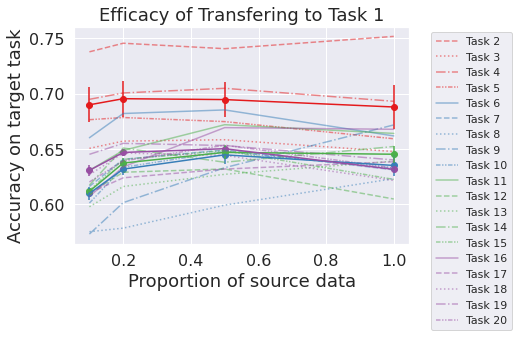

In [96]:
fig, ax = plt.subplots(1,1)
ls=['-','--', ':', '-.', (0, (3, 1, 1, 1, 1, 1))]

colors = sns.color_palette("Set1", n_colors=5)

for i, source_task in enumerate(source_tasks, 1):
    ax.plot(props_source, mean_accuracies[i-1], label='Task %i'%(i+1), c=colors[int(np.math.floor(i/5))],
            alpha=0.5,
            ls=ls[i % 5])
    
for i in range(n_task_types):
    if i == 0:
        temp_mean = np.mean(mean_accuracies[:4], axis=0)
        temp_std = np.std(mean_accuracies[:4], ddof=0, axis=0) / np.sqrt(4)
    else:
        temp_mean = np.mean(mean_accuracies[4 + n_task_types*i: 4+n_task_types*(i+1)], axis=0)
        temp_std = np.std(mean_accuracies[4 + n_task_types*i: 4+n_task_types*(i+1)], ddof=0, axis=0) / np.sqrt(5)
                          
    ax.scatter(props_source, temp_mean, c=colors[i])
    ax.errorbar(props_source, temp_mean, yerr=1*temp_std, c=colors[i])
    
    

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel('Proportion of source data', fontsize=18)
ax.set_ylabel('Accuracy on target task', fontsize=18)
ax.set_title('Efficacy of Transfering to Task 1', fontsize=18)

ax.tick_params(labelsize=16)

In [ ]:
n_props = [0.05, 0.1, 0.15, 0.2, 0.25]

models = {prop: {'coarse': None, 
                 'fine': {i: None for i in range(len(idx_by_coarse))},
                 'flat': None,
                } for prop in n_props}

coarse_labels_to_use = np.arange(20)

# Resource control
n_trees_coarse = 200
n_trees_fine = 25
# n_trees_flat = 10
n_trees_flat = n_trees_coarse + (20 * n_trees_fine)

for i, prop in enumerate(tqdm(n_props)):
    indices_by_coarse_label = np.array([
                            np.random.choice(ibc, size = int(prop*len(ibc)), replace=False) 
                            for ibc in idx_by_coarse[coarse_labels_to_use]
                              ])
    X = trainset.data[np.concatenate(indices_by_coarse_label)]
    
    coarse_forest = l2f(n_estimators=n_trees_coarse,
                        default_finite_sample_correction=False,
                        default_max_depth=None)
    coarse_forest.add_task(X, coarse_targets[np.concatenate(indices_by_coarse_label)])
    models[prop]['coarse'] = coarse_forest
#     print('done coarse')
    
    flat_forest = l2f(n_estimators=n_trees_flat,
                        default_finite_sample_correction=False,
                        default_max_depth=None)
    flat_forest.add_task(X, np.array(trainset.targets)[np.concatenate(indices_by_coarse_label)])
    models[prop]['flat'] = flat_forest
#     print('done flat')
    
    for j, inds in enumerate(indices_by_coarse_label[coarse_labels_to_use]):
        X = trainset.data[inds]
        
        fine_forest = l2f(n_estimators=n_trees_fine, 
                               default_finite_sample_correction=False, 
                               default_max_depth=None
                              )
        fine_forest.add_task(X, np.array(trainset.targets)[inds])
        models[prop]['fine'][j] = fine_forest
#         print('done fine')